In [1]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image
import os

%matplotlib inline

CMIX found.


In [2]:
def load_image(img, gray=True):
    photo = load_img(img,  grayscale=gray)
    # convert to numpy array
    photo = img_to_array(photo, dtype='uint8')
    print(photo.shape)
    if gray: 
        photo.resize(photo.shape[0], photo.shape[1])
    return photo

In [194]:
def print_data(data, prec):
    print(",".join([str(round(f,prec)) for f in data]))

## River extraction through blue channel thresholding

In [253]:
photo_color = load_image('../data/Cascades_topo_edifices3d.jpg', gray=False)
blue = photo_color[:,:,2]
print(blue.shape)
blue_list = blue.tolist()
for i in range(len(blue_list)):
    for j in range(len(blue_list[0])):
        if 49 < blue_list[i][j] < 65 :
            blue_list[i][j] = 1.
        else:
            blue_list[i][j] = 255.

(3623, 1216, 3)
(3623, 1216)


In [254]:
blue_list_res = cv2.resize(np.array(blue_list), dsize=(134, 400))
print(blue_list_res.shape)

(400, 134)


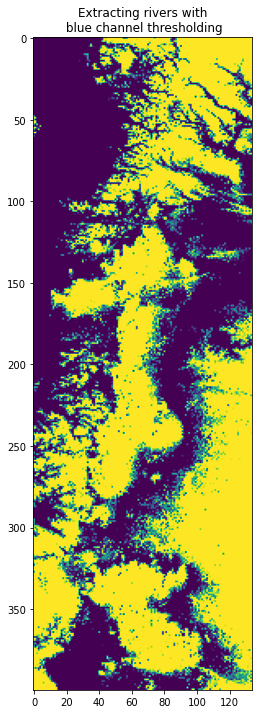

In [265]:
fig, ax = plt.subplots(figsize=(4,12))

plt.imshow(np.array(blue_list_res))
plt.title("Extracting rivers with\n blue channel thresholding")
plt.show()

In [102]:
import json
#print(json.dumps([[round(b,3) for b in row] for row in blue_list_res]))

In [124]:
percents_riv_left = []
percents_riv_right = []
n = len(blue_list_res[0])
half = n//2
for row in blue_list_res.tolist():
    percents_riv_left.append(row[:half].count(1)/half)
    percents_riv_right.append(row[half:].count(1)/half)

#### To sonify: (MMODALBAR)

1. Amp: percent river 
2. Pan: left and right river 
3. Hardness: percent river
4. Position: percent river

#### To visualize 

1. extracted river pixels 

In [128]:
# print(",".join([str(round(p, 3)) for p in percents_riv_left]))
# print(",".join([str(round(p, 3)) for p in percents_riv_reft]))

## Elevation and terrain through gradients, divergence, variance...

In [130]:
photo = load_image('../data/Cascades_topo_edifices3d.jpg', gray=True)
print(photo.shape)

(3623, 1216, 1)
(3623, 1216)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [134]:
# get gradient
res_photo = cv2.resize(photo, dsize=(134, 400))

print(np.max(res_photo))
res_photo  = res_photo / np.max(res_photo)
grad_photo = np.array(np.gradient(res_photo))
print(grad_photo.shape)

190
(2, 400, 134)


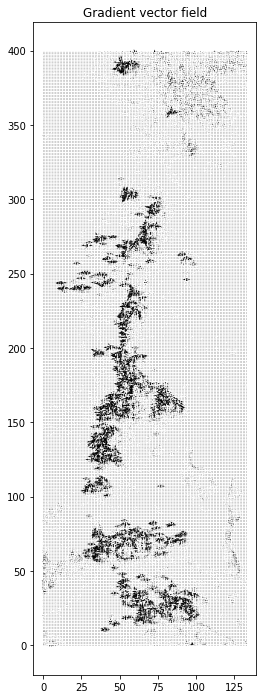

In [258]:
# plot vector field 
fig, ax = plt.subplots(figsize=(4,12 ))
u,v = grad_photo[1][::-1], grad_photo[0][::-1]
x,y = [i for i in range(grad_photo.shape[2])], [i for i in range(grad_photo.shape[1])]
plt.title("Gradient vector field")
plt.quiver(x,y, u, v)
plt.show()

In [135]:
def divergence(f):
    """
    Computes the divergence of the vector field f, corresponding to dFx/dx + dFy/dy + ...
    :param f: List of ndarrays, where every item of the list is one dimension of the vector field
    :return: Single ndarray of the same shape as each of the items in f, which corresponds to a scalar field
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])

In [136]:
div = divergence(grad_photo)

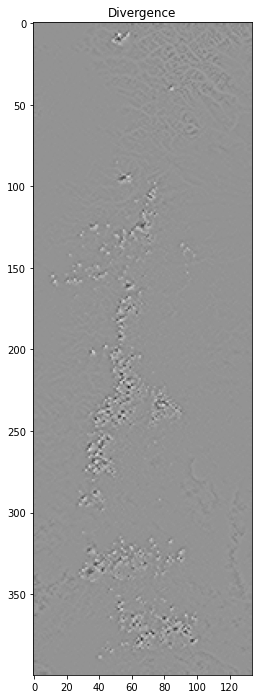

In [165]:
fig, ax = plt.subplots(figsize=(4,12 ))
plt.imshow(div, cmap="gray")
plt.title("Divergence")
plt.show()

In [140]:
#calculate the magnitude of the gradient at each point
grad_norm = [[0]*len(grad_photo[1][0])]*len(grad_photo[0])
grad_norm = []
print(np.array(grad_norm).shape)
for r in range(len(grad_photo[0])):
    vec = []
    for c in range(len(grad_photo[0][0])):
        a = grad_photo[0][r][c]
        b = grad_photo[1][r][c]
        norm = np.linalg.norm([a,b])
        vec.append(norm)
    grad_norm.append(vec)
grad_norm = np.array(grad_norm)
print(grad_norm)
print(np.min(grad_norm))   

(0,)
[[0.00744323 0.00588439 0.00526316 ... 0.03328713 0.02170056 0.05263158]
 [0.00948829 0.00588439 0.00744323 ... 0.01664357 0.00526316 0.05425139]
 [0.02248422 0.00588439 0.         ... 0.0500692  0.02368421 0.02170056]
 ...
 [0.02170056 0.00588439 0.03297359 ... 0.02426196 0.02121647 0.05954583]
 [0.01897659 0.03179749 0.02631579 ... 0.02368421 0.03328713 0.0437982 ]
 [0.04340111 0.03912123 0.02121647 ... 0.01315789 0.02353756 0.03370065]]
0.0


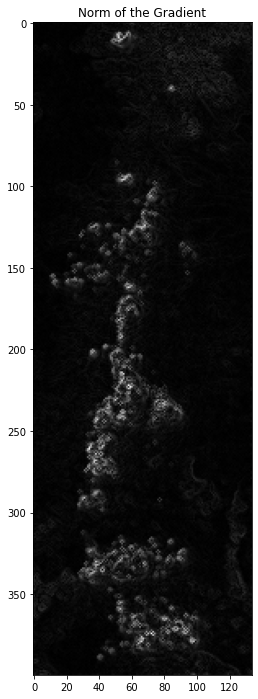

In [260]:
fig, ax = plt.subplots(figsize=(4,12))
plt.imshow(np.array(grad_norm), cmap="gray")
plt.title("Norm of the Gradient")
plt.show()

In [179]:
# average grad norm and max grad norm of each row
norm_avg = []
norm_max = []
norm_min = []
norm_max_idx = []
for i,row in enumerate(grad_norm):
    norm_avg.append(np.average(row))
    norm_max.append(max(row))
    norm_max_idx.append(np.where(row == max(row))[0][0])
    norm_min.append(min(row))
    
print(max(norm_max))
print(min(norm_max))

0.4270785898211903
0.026315789473684216


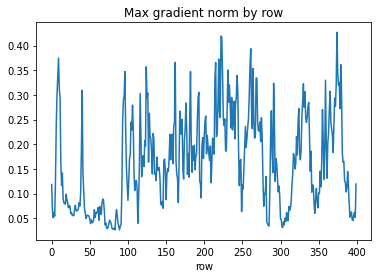

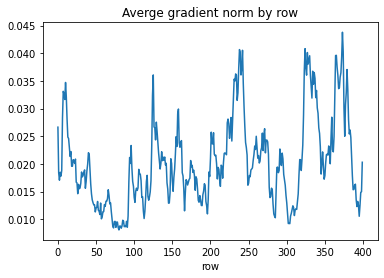

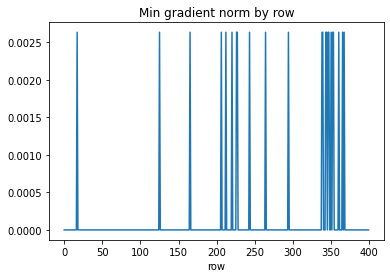

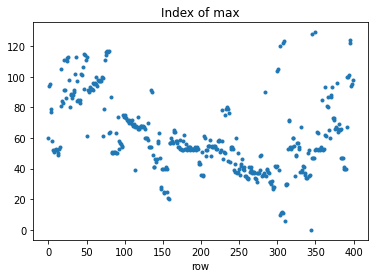

In [184]:
# visualizing these vertically makes more sense 
plt.plot(np.arange(len(norm_max)), norm_max)
plt.title("Max gradient norm by row")
plt.xlabel("row")
plt.show()

plt.plot(np.arange(len(norm_max)), norm_avg)
plt.title("Averge gradient norm by row")
plt.xlabel("row")
plt.show()

plt.plot(np.arange(len(norm_min)), norm_min)
plt.title("Min gradient norm by row")
plt.xlabel("row")
plt.show()

plt.scatter(np.arange(len(norm_min)), norm_max_idx, marker='.')
plt.title("Index of max")
plt.xlabel("row")
plt.show()

In [146]:
# variance of each row
variance_by_row = np.var(grad_norm, axis=1)

In [226]:
variance_thresholded = []
for var in variance_by_row:
    if var > 0.002:
        variance_thresholded.append(1)
    else:
        variance_thresholded.append(0)

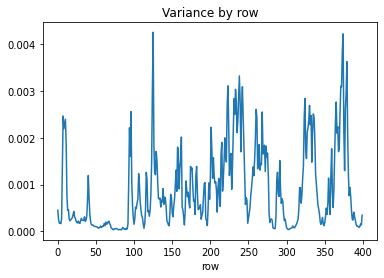

In [149]:
plt.plot(np.arange(len(variance_by_row)), variance_by_row)
plt.title("Variance by row")
plt.xlabel("row")
plt.show()

#### To sonify:

1. Pitch: max grad norm
2. Pitch jitter: variance 
3. Amp: max grad norm
4. Strums: variance thresholded
5. Pan: index of max

#### To animate:

1. Index of max -> pixel location
2. Max norm -> color/size of pixel

In [231]:
pitch_range = [6.7,9.7]
amp_range = [2000,15000]
jitter_range = pan_range = [0.1,1]
pitches = np.interp(norm_max,[min(norm_max),max(norm_max)], pitch_range)
amps = np.interp(norm_max,[min(norm_max),max(norm_max)], amp_range)
jitter = np.interp(variance_by_row,[min(variance_by_row),max(variance_by_row)], jitter_range)
pan = np.interp(norm_max_idx,[0,134], pan_range)


In [261]:
#print_data(pitches,3)
#print_data(amps,1)
print_data(jitter,3)
#print_data(pan, 3)
#print_data(something,3 )

0.235,0.195,0.179,0.181,0.177,0.198,0.433,0.64,0.585,0.605,0.626,0.521,0.291,0.234,0.235,0.195,0.189,0.194,0.198,0.202,0.214,0.229,0.206,0.2,0.187,0.182,0.18,0.188,0.179,0.178,0.19,0.2,0.192,0.191,0.191,0.206,0.186,0.193,0.209,0.282,0.384,0.287,0.219,0.186,0.172,0.171,0.171,0.167,0.165,0.165,0.164,0.163,0.163,0.157,0.158,0.16,0.167,0.16,0.163,0.167,0.166,0.178,0.169,0.184,0.175,0.177,0.185,0.188,0.177,0.171,0.158,0.156,0.152,0.151,0.155,0.154,0.155,0.156,0.154,0.151,0.151,0.151,0.152,0.15,0.153,0.16,0.159,0.153,0.154,0.151,0.157,0.154,0.177,0.362,0.589,0.466,0.659,0.353,0.254,0.2,0.174,0.2,0.248,0.242,0.267,0.283,0.392,0.344,0.271,0.237,0.211,0.202,0.176,0.157,0.177,0.236,0.398,0.366,0.228,0.233,0.209,0.233,0.299,0.438,0.75,1.0,0.512,0.4,0.387,0.488,0.448,0.354,0.284,0.284,0.287,0.248,0.278,0.27,0.328,0.26,0.291,0.288,0.25,0.189,0.182,0.171,0.168,0.224,0.303,0.289,0.223,0.206,0.253,0.28,0.338,0.407,0.316,0.506,0.494,0.327,0.414,0.449,0.549,0.248,0.237,0.207,0.171,0.231,0.361,0.323,0.29

In [222]:
#print_data(np.interp(norm_max,[min(norm_max),max(norm_max)], [0.2,1]), 3)

In [237]:
print_data(np.interp(variance_by_row,[min(variance_by_row),max(variance_by_row)], [5.6,6.8]), 2)

5.72,5.66,5.64,5.64,5.64,5.67,6.0,6.29,6.21,6.24,6.27,6.12,5.8,5.72,5.72,5.66,5.66,5.66,5.67,5.67,5.69,5.71,5.68,5.67,5.65,5.65,5.64,5.65,5.64,5.64,5.66,5.67,5.66,5.66,5.66,5.68,5.65,5.66,5.68,5.79,5.93,5.79,5.7,5.65,5.63,5.63,5.63,5.62,5.62,5.62,5.62,5.62,5.62,5.61,5.61,5.61,5.62,5.61,5.62,5.62,5.62,5.64,5.63,5.65,5.64,5.64,5.65,5.65,5.64,5.63,5.61,5.61,5.6,5.6,5.61,5.61,5.61,5.61,5.61,5.6,5.6,5.6,5.6,5.6,5.6,5.61,5.61,5.6,5.61,5.6,5.61,5.61,5.64,5.9,6.22,6.05,6.32,5.89,5.75,5.67,5.63,5.67,5.74,5.73,5.77,5.79,5.94,5.87,5.77,5.72,5.69,5.67,5.64,5.61,5.64,5.72,5.95,5.9,5.71,5.72,5.68,5.72,5.81,6.01,6.45,6.8,6.11,5.95,5.94,6.08,6.02,5.89,5.79,5.79,5.79,5.74,5.78,5.77,5.85,5.76,5.8,5.79,5.74,5.66,5.64,5.63,5.62,5.7,5.82,5.8,5.7,5.68,5.75,5.78,5.87,5.96,5.83,6.1,6.09,5.85,5.97,6.02,6.16,5.74,5.72,5.68,5.63,5.71,5.9,5.84,5.8,5.83,5.76,5.73,5.99,5.96,5.98,5.86,5.78,5.78,5.69,5.93,5.99,5.82,5.72,5.73,5.74,5.75,5.67,5.69,5.71,5.8,5.88,5.89,5.67,5.66,5.63,5.72,5.89,5.79,5.91,6.22,6.08,5.91,6.04

In [227]:
print(variance_thresholded)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 